---
## Step 0: Load The Data

In [1]:
# Import libs
import tensorflow as tf
import keras
import pickle

Using TensorFlow backend.


In [2]:
# Load data
import pickle

training_file = "dataset/train.p"
validation_file= "dataset/valid.p"
testing_file = "dataset/test.p"

# Read
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# shape
print(X_train.shape)
print(y_train.shape)


(34799, 32, 32, 3)
(34799,)


In [3]:
# Train length
n_train = X_train.shape[0]

# Valid length
n_validation = X_valid.shape[0]

# Test length
n_test = X_test.shape[0]

# Image length
image_shape = X_train.shape[1:]

# Num of classes
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


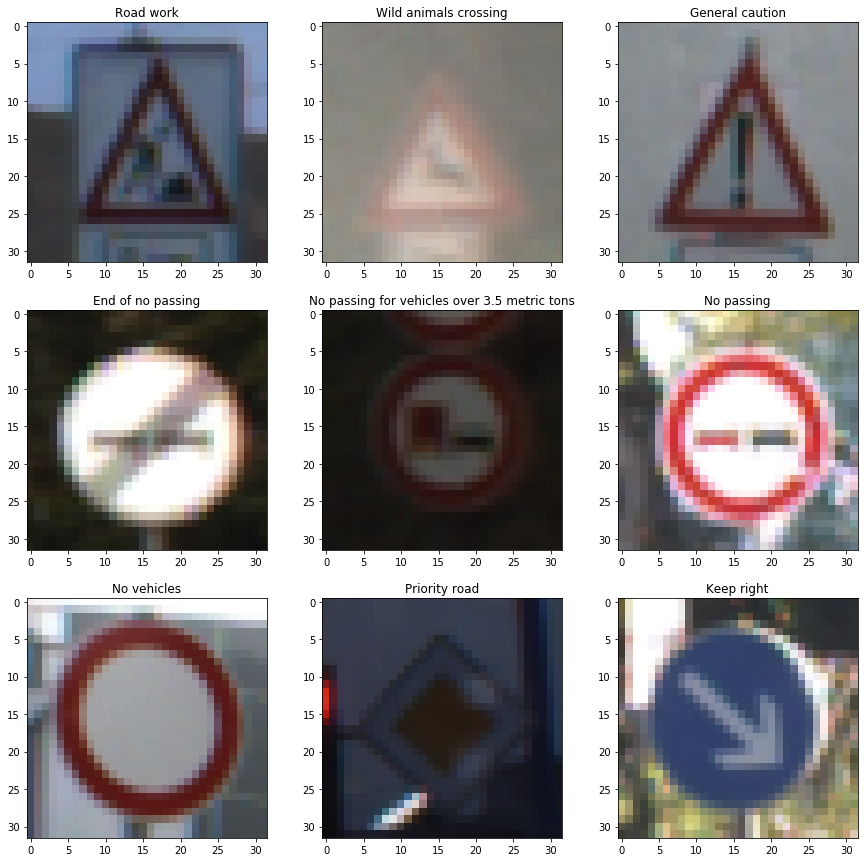

/home/williamlaw/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Most common index
index: 2 => Speed limit (50km/h) = 0.0591355252408731
index: 1 => Speed limit (30km/h) = 0.05825290546115858
index: 13 => Yield = 0.056487665901729524
index: 12 => Priority road = 0.055605046122015
index: 38 => Keep right = 0.05472242634230058
index: 10 => No passing for vehicles over 3.5 metric tons = 0.05295718678287143
index: 4 => Speed limit (70km/h) = 0.05207456700315691
index: 5 => Speed limit (80km/h) = 0.048544087884298814
index: 25 => Road work = 0.0397178900871535
index: 9 => No passing = 0.03883527030743905


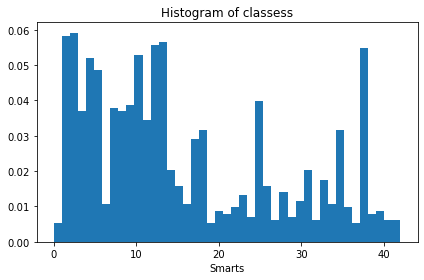

In [4]:
# Visualize data
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import random
from PIL import Image, ImageEnhance

%matplotlib inline

# Load ids for each class
with open("signnames.csv", "r") as f:
    signnames = f.read()
id_to_name = { int(line.split(",")[0]):line.split(",")[1] for line in signnames.split("\n")[1:] if len(line) > 0}

# Graph properties
graph_size = 3
random_index_list = [random.randint(0, X_train.shape[0]) for _ in range(graph_size * graph_size)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_index_list):
    a=fig.add_subplot(graph_size, graph_size, i+1)
    
    # Show train images
    imgplot = plt.imshow(X_train[index])
    a.set_title('%s' % id_to_name[y_train[index]])

plt.show()
fig, ax = plt.subplots()

# Histogram graph
values, bins, patches = ax.hist(y_train, n_classes, normed=10)

# Line of best fit
ax.set_xlabel('Smarts')
ax.set_title(r'Histogram of classess')

fig.tight_layout()
print ("Most common index")
most_common_index = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
for index in most_common_index[:10]:
    print("index: %s => %s = %s" % (index, id_to_name[index], values[index]))

In [5]:
# Preprocess data
from keras.preprocessing.image import ImageDataGenerator

X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

In [6]:
def preprocessing_function(img):
    img = img * 255
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.6, 1.5))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.6, 1.5))

    return np.array(img) / 255

train_datagen = ImageDataGenerator()
train_datagen_augmented = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocessing_function
)
inference_datagen = ImageDataGenerator()
train_datagen.fit(X_train)
train_datagen_augmented.fit(X_train)
inference_datagen.fit(X_valid)
inference_datagen.fit(X_test)

### Example of augmented images

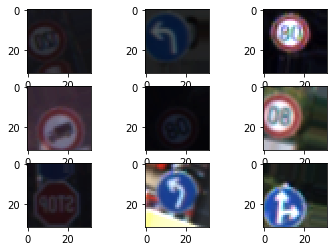

In [7]:
# Show augmented images
fig = plt.figure()

n = 0
graph_size = 3

# Loop through all the augmented img
for x_batch, y_batch in train_datagen_augmented.flow(X_train, y_train, batch_size=1):
    a=fig.add_subplot(graph_size, graph_size, n+1)
    imgplot = plt.imshow(x_batch[0])
    n = n + 1
    if n > 8:
        break

# Show
plt.show()

## Model Architecture

### CapsNet

In [8]:
# Architecture
import numpy as np


def conv_caps_layer(input_layer, capsules_size, nb_filters, kernel, stride=2):
    # Capsules -> output grid of vectors rather than single vector
    capsules = tf.contrib.layers.conv2d(
        input_layer, nb_filters * capsules_size, kernel, stride, padding="VALID")
    
    # Get current shape -> reshape
    shape = capsules.get_shape().as_list()
    capsules = tf.reshape(capsules, shape=(-1, np.prod(shape[1:3]) * nb_filters, capsules_size, 1))
    
    return squash(capsules)

# Dynamic routing algorithm
def routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=4):
    """
        u_hat: weights b/w prev caps + current caps
        b_ij: log probs of matching current to next caps
        nb_capsules: num of caps in prev layer
        nb_capsules: num of caps in current layer
    """
    
    # Algorithm
    for it in range(iterations):
        with tf.variable_scope('routing_' + str(it)):
            # Probs caps current to pair to next
            c_ij = tf.nn.softmax(b_ij, dim=2)

            
            s_j = tf.multiply(c_ij, u_hat)
            s_j = tf.reduce_sum(s_j, axis=1, keep_dims=True)

            v_j = squash(s_j)

            v_j_tiled = tf.tile(v_j, [1, nb_capsules_p, 1, 1, 1])
            u_dot_v = tf.matmul(u_hat, v_j_tiled, transpose_a=True)
            b_ij += tf.reduce_sum(u_dot_v, axis=0, keep_dims=True)

    return tf.squeeze(v_j, axis=1)

# FCP layers ~ encoders
def fully_connected_caps_layer(input_layer, capsules_size, nb_capsules, iterations=4):
    shape = input_layer.get_shape().as_list()
    
    # Get size of prev and current layer
    len_u_i = np.prod(shape[2])
    len_v_j = capsules_size
    
    # Get num. of capsules in prev layer
    nb_capsules_p = np.prod(shape[1])

    _init = tf.random_normal_initializer(stddev=0.01, seed=0)
    _shape = (nb_capsules_p, nb_capsules, len_v_j, len_u_i)
    
    # Multiply output capsule in the prev layer
    w_ij = tf.get_variable('weight', shape=_shape, dtype=tf.float32, initializer=_init)

    # Dot product calculation
    input_layer = tf.reshape(input_layer, shape=(-1, nb_capsules_p, 1, len_u_i, 1))
    input_layer = tf.tile(input_layer, [1, 1, nb_capsules, 1, 1])

    # Associate prev cap to current cap
    u_hat = tf.einsum('abdc,iabcf->iabdf', w_ij, input_layer)

    # Taking log probs that current caps to be paired to next caps
    b_ij = tf.zeros(shape=[nb_capsules_p, nb_capsules, 1, 1], dtype=np.float32)

    return routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=iterations)

# Condense vector to length <= 1
def squash(vector):
    vector += 0.00001 
    vec_squared_norm = tf.reduce_sum(tf.square(vector), -2, keep_dims=True)
    scalar_factor = vec_squared_norm / (1 + vec_squared_norm) / tf.sqrt(vec_squared_norm)
    vec_squashed = scalar_factor * vector
    
    return(vec_squashed)

### Main Model

In [9]:
from model_base import ModelBase

class ModelTrafficSign(ModelBase):
    # Numbers of label to predict
    NB_LABELS = 43

    def __init__(self, model_name, output_folder):
        # Take current model and output to saved data
        ModelBase.__init__(self, model_name, output_folder=output_folder)

    # Placeholder for images
    def _build_inputs(self):
        # Images 32*32*3
        tf_images = tf.placeholder(tf.float32, [None, 32, 32, 3], name='images')
        tf_labels = tf.placeholder(tf.int64, [None], name='labels')
    
        return tf_images, tf_labels

    # Create 2 convo layers
    def _build_main_network(self, images, conv_2_dropout):
        # First convo layer
        shape = (self.h.conv_1_size, self.h.conv_1_size, 3, self.h.conv_1_nb)
        conv1 = self._create_conv(self.tf_images, shape, relu=True, max_pooling=False, padding='VALID')
        
        # Second convo layer
        conv1 = tf.nn.dropout(conv1, keep_prob=conv_2_dropout)

        # Create the first capsules layer
        caps1 = conv_caps_layer(
            input_layer=conv1,
            capsules_size=self.h.caps_1_vec_len,
            nb_filters=self.h.caps_1_nb_filter,
            kernel=self.h.caps_1_size)
        
        # Create the second capsules layer used to predict the output
        caps2 = fully_connected_caps_layer(
            input_layer=caps1,
            capsules_size=self.h.caps_2_vec_len,
            nb_capsules=self.NB_LABELS,
            iterations=self.h.routing_steps)

        return caps1, caps2

    def _build_decoder(self, caps2, one_hot_labels, batch_size):
        # Decoder using last capsule
        labels = tf.reshape(one_hot_labels, (-1, self.NB_LABELS, 1))
        mask = tf.matmul(tf.squeeze(caps2), labels, transpose_a=True)
        capsule_vector = tf.reshape(mask, shape=(batch_size, self.h.caps_2_vec_len))

        # Reconstruct image
        fc1 = tf.contrib.layers.fully_connected(capsule_vector, num_outputs=400)
        fc1 = tf.reshape(fc1, shape=(batch_size, 5, 5, 16))
        upsample1 = tf.image.resize_nearest_neighbor(fc1, (8, 8))
        conv1 = tf.layers.conv2d(upsample1, 4, (3,3), padding='same', activation=tf.nn.relu)

        upsample2 = tf.image.resize_nearest_neighbor(conv1, (16, 16))
        conv2 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)

        upsample3 = tf.image.resize_nearest_neighbor(conv2, (32, 32))
        conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)

        # 3 channel for RGG
        logits = tf.layers.conv2d(conv6, 3, (3,3), padding='same', activation=None)
        decoded = tf.nn.sigmoid(logits, name='decoded')
        tf.summary.image('reconstruction_img', decoded)

        return decoded

    def init(self):
        # Get inputs from graph
        self.tf_images, self.tf_labels = self._build_inputs()
        
        # Dropout
        self.tf_conv_2_dropout = tf.placeholder(tf.float32, shape=(), name='conv_2_dropout')
        
        # Dynamic batch size
        batch_size = tf.shape(self.tf_images)[0]
        
        # Take labels -> encode to one-hot array
        one_hot_labels = tf.one_hot(self.tf_labels, depth=self.NB_LABELS)
        
        # Create first convo + CapsNet
        self.tf_caps1, self.tf_caps2 = self._build_main_network(self.tf_images, self.tf_conv_2_dropout)

        # Reconstruct image
        self.tf_decoded = self._build_decoder(self.tf_caps2, one_hot_labels, batch_size)

        # Build the loss
        _loss = self._build_loss(
            self.tf_caps2, one_hot_labels, self.tf_labels, self.tf_decoded, self.tf_images)
        (self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_predicted_class,
         self.tf_correct_prediction, self.tf_accuracy, self.tf_loss, self.tf_margin_loss,
         self.tf_reconstruction_loss) = _loss

        # Build optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.h.learning_rate)
        self.tf_optimizer = optimizer.minimize(self.tf_loss, global_step=tf.Variable(0, trainable=False))

        # Log value into tensorboard
        tf.summary.scalar('margin_loss', self.tf_margin_loss)
        tf.summary.scalar('accuracy', self.tf_accuracy)
        tf.summary.scalar('total_loss', self.tf_loss)
        tf.summary.scalar('reconstruction_loss', self.tf_reconstruction_loss)

        self.tf_test = tf.random_uniform([2], minval=0, maxval=None, dtype=tf.float32, seed=None, name="tf_test")

        self.init_session()


    # Loss function
    def _build_loss(self, caps2, one_hot_labels, labels, decoded, images):
        # Get the length
        capsules_length = tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keep_dims=True))

        max_l = tf.square(tf.maximum(0., 0.9 - capsules_length))
        max_l = tf.reshape(max_l, shape=(-1, self.NB_LABELS))
        max_r = tf.square(tf.maximum(0., capsules_length - 0.1))
        max_r = tf.reshape(max_r, shape=(-1, self.NB_LABELS))
        t_c = one_hot_labels
        m_loss = t_c * max_l + 0.5 * (1 - t_c) * max_r
        margin_loss_sum = tf.reduce_sum(m_loss, axis=1)
        margin_loss = tf.reduce_mean(margin_loss_sum)

        # Reconstruction loss
        loss_squared_rec = tf.square(decoded - images)
        reconstruction_loss = tf.reduce_mean(loss_squared_rec)

        # Total
        loss = margin_loss + (0.0005 * reconstruction_loss)

        # Accuracy
        predicted_class = tf.argmax(capsules_length, axis=1)
        predicted_class = tf.reshape(predicted_class, [tf.shape(capsules_length)[0]])
        correct_prediction = tf.equal(predicted_class, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        return (loss_squared_rec, margin_loss_sum, predicted_class, correct_prediction, accuracy,
                loss, margin_loss, reconstruction_loss)

    # Return loss and acc of model for this current batch
    def optimize(self, images, labels, tb_save=True):
        tensors = [self.tf_optimizer, self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        _, loss, acc, summary = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: self.h.conv_2_dropout
        })

        if tb_save:
            # Write data
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def evaluate(self, images, labels, tb_train_save=False, tb_test_save=False):
        tensors = [self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        loss, acc, summary = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images,
                self.tf_labels: labels,
                self.tf_conv_2_dropout: 1.
            })

        if tb_test_save:
            # Write data 
            self.test_writer.add_summary(summary, self.test_writer_it)
            self.test_writer_it += 1

        if tb_train_save:
            # Write data 
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    # Pred class
    def predict(self, images):
        tensors = [self.tf_caps2]

        caps2 = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_conv_2_dropout: 1.
        })[0]

        caps2 = np.sqrt(np.sum(np.square(caps2), axis=2, keepdims=True))
        caps2 = np.reshape(caps2, (len(images), self.NB_LABELS))
        
        softmax = np.exp(caps2) / np.sum(np.exp(caps2), axis=1, keepdims=True)

        return softmax

    def reconstruction(self, images, labels):
        # Reconstruct image from encoder
        tensors = [self.tf_decoded]

        decoded = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: 1.
        })[0]

        return decoded

    def evaluate_dataset(self, images, labels, batch_size=10):
        # Evaluate data per batch
        # Takes images as input -> outputs loss, acc + pred class
        
        tensors = [self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_correct_prediction,
                   self.tf_predicted_class]

        loss_squared_rec_list = None
        margin_loss_sum_list = None
        correct_prediction_list = None
        predicted_class = None

        b = 0
        for batch in self.get_batches([images, labels], batch_size, shuffle=False):
            images_batch, labels_batch = batch
            loss_squared_rec, margin_loss_sum, correct_prediction, classes = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images_batch,
                self.tf_labels: labels_batch,
                self.tf_conv_2_dropout: 1.
            })
            if loss_squared_rec_list is not None:
                predicted_class = np.concatenate((predicted_class, classes))
                loss_squared_rec_list = np.concatenate((loss_squared_rec_list, loss_squared_rec))
                margin_loss_sum_list = np.concatenate((margin_loss_sum_list, margin_loss_sum))
                correct_prediction_list = np.concatenate((correct_prediction_list, correct_prediction))
            else:
                predicted_class = classes
                loss_squared_rec_list = loss_squared_rec
                margin_loss_sum_list = margin_loss_sum
                correct_prediction_list = correct_prediction
            b += batch_size

        margin_loss = np.mean(margin_loss_sum_list)
        reconstruction_loss = np.mean(loss_squared_rec_list)
        accuracy = np.mean(correct_prediction_list)

        loss = margin_loss

        return loss, accuracy, predicted_class

In [10]:
# Train + validate + test
model = ModelTrafficSign("TrafficSign", output_folder="outputs")
model.init()

W1028 19:57:04.991456 140307896850240 deprecation_wrapper.py:119] From /home/williamlaw/Desktop/Projects/Novel-Deep-Learning-Model-for-Traffic-Sign-Detection-Using-Capsule-Networks/model_base.py:91: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

From /home/williamlaw/Desktop/Projects/Novel-Deep-Learning-Model-for-Traffic-Sign-Detection-Using-Capsule-Networks/model_base.py:91: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1028 19:57:05.045104 140307896850240 deprecation.py:506] From <ipython-input-9-b27ddab8c87f>:57: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
From <ipython-input-9-b27ddab8c87f>:57: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a fut

In [12]:
BATCH_SIZE = 2

# Print stats
def plot_progression(b, cost, acc, label): print(
    "[%s] Batch ID = %s, loss = %s, acc = %s" % (label, b, cost, acc))

# Training pipeline
b = 0
valid_batch = inference_datagen.flow(X_valid, y_valid, batch_size=BATCH_SIZE)
best_validation_loss = None
augmented_factor = 0.99
decrease_factor = 0.90
train_batches = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
augmented_train_batches = train_datagen_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE)

while True:
    next_batch = next(
        augmented_train_batches if random.uniform(0, 1) < augmented_factor else train_batches)
    x_batch, y_batch = next_batch

    # Training
    cost, acc = model.optimize(x_batch, y_batch)
    
    # Validation
    x_batch, y_batch = next(valid_batch, None)
    
    # Get cost + acc
    cost_val, acc_val = model.evaluate(x_batch, y_batch, tb_test_save=True)

    # Prev results
    if b % 10 == 0: 
        plot_progression(b, cost, acc, "Train")
        plot_progression(b, cost_val, acc_val, "Validation")
    
    # Validate
    if b % 1000 == 0:
        print("Evaluate full validation dataset ...")
        loss, acc, _ = model.evaluate_dataset(X_valid, y_valid)
        print("Current loss: %s Best loss: %s" % (loss, best_validation_loss))
        plot_progression(b, loss, acc, "TOTAL Validation")
        if best_validation_loss is None or loss < best_validation_loss:
            best_validation_loss = loss
            model.save()
        augmented_factor = augmented_factor * decrease_factor
        print("Augmented Factor = %s" % augmented_factor)

    b += 1

[Train] Batch ID = 0, loss = 0.7290379, acc = 0.0
[Validation] Batch ID = 0, loss = 1.9575502, acc = 0.0
Evaluate full validation dataset ...


I1028 19:59:28.177571 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 1.3306696 Best loss: None
[TOTAL Validation] Batch ID = 0, loss = 1.3306696, acc = 0.035147392290249435


I1028 19:59:29.229172 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.891
[Train] Batch ID = 10, loss = 0.7832258, acc = 0.0
[Validation] Batch ID = 10, loss = 0.78313315, acc = 0.0
[Train] Batch ID = 20, loss = 0.7269343, acc = 0.5
[Validation] Batch ID = 20, loss = 0.5642473, acc = 0.0
[Train] Batch ID = 30, loss = 0.7840333, acc = 0.0
[Validation] Batch ID = 30, loss = 0.6656508, acc = 0.0
[Train] Batch ID = 40, loss = 0.7708478, acc = 0.0
[Validation] Batch ID = 40, loss = 0.5889417, acc = 0.0
[Train] Batch ID = 50, loss = 0.80017257, acc = 0.0
[Validation] Batch ID = 50, loss = 0.6215699, acc = 0.0
[Train] Batch ID = 60, loss = 0.64622784, acc = 0.0
[Validation] Batch ID = 60, loss = 0.72736824, acc = 0.0
[Train] Batch ID = 70, loss = 0.5461259, acc = 0.0
[Validation] Batch ID = 70, loss = 0.7627679, acc = 0.0
[Train] Batch ID = 80, loss = 0.7507109, acc = 0.0
[Validation] Batch ID = 80, loss = 0.541697, acc = 0.0
[Train] Batch ID = 90, loss = 0.6070315, acc = 0.0
[Validation] Batch ID = 90, loss = 0.62132215, acc = 0.0
[Train] 

[Train] Batch ID = 760, loss = 0.70891684, acc = 0.0
[Validation] Batch ID = 760, loss = 0.6696712, acc = 0.0
[Train] Batch ID = 770, loss = 0.5628142, acc = 0.5
[Validation] Batch ID = 770, loss = 0.6958399, acc = 0.0
[Train] Batch ID = 780, loss = 0.6773743, acc = 0.0
[Validation] Batch ID = 780, loss = 0.63911474, acc = 0.0
[Train] Batch ID = 790, loss = 0.68868625, acc = 0.0
[Validation] Batch ID = 790, loss = 0.6524378, acc = 0.0
[Train] Batch ID = 800, loss = 0.7405182, acc = 0.0
[Validation] Batch ID = 800, loss = 0.4662421, acc = 0.5
[Train] Batch ID = 810, loss = 0.4737339, acc = 0.5
[Validation] Batch ID = 810, loss = 0.58304405, acc = 0.0
[Train] Batch ID = 820, loss = 0.6874589, acc = 0.0
[Validation] Batch ID = 820, loss = 0.51427066, acc = 0.5
[Train] Batch ID = 830, loss = 0.64666355, acc = 0.0
[Validation] Batch ID = 830, loss = 0.5757811, acc = 0.0
[Train] Batch ID = 840, loss = 0.615551, acc = 0.0
[Validation] Batch ID = 840, loss = 0.5462328, acc = 0.5
[Train] Batch 

I1028 20:04:07.129014 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.6075835 Best loss: 1.3306696
[TOTAL Validation] Batch ID = 1000, loss = 0.6075835, acc = 0.10090702947845805


I1028 20:04:10.336126 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.8019000000000001
[Train] Batch ID = 1010, loss = 0.67862654, acc = 0.0
[Validation] Batch ID = 1010, loss = 0.49653745, acc = 0.0
[Train] Batch ID = 1020, loss = 0.617591, acc = 0.0
[Validation] Batch ID = 1020, loss = 0.6796451, acc = 0.0
[Train] Batch ID = 1030, loss = 0.66877353, acc = 0.0
[Validation] Batch ID = 1030, loss = 0.46584728, acc = 0.5
[Train] Batch ID = 1040, loss = 0.71765316, acc = 0.0
[Validation] Batch ID = 1040, loss = 0.4921399, acc = 0.0
[Train] Batch ID = 1050, loss = 0.5544223, acc = 0.0
[Validation] Batch ID = 1050, loss = 0.6141243, acc = 0.0
[Train] Batch ID = 1060, loss = 0.60090154, acc = 0.0
[Validation] Batch ID = 1060, loss = 0.6268845, acc = 0.0
[Train] Batch ID = 1070, loss = 0.6023427, acc = 0.0
[Validation] Batch ID = 1070, loss = 0.560861, acc = 0.0
[Train] Batch ID = 1080, loss = 0.6488853, acc = 0.0
[Validation] Batch ID = 1080, loss = 0.76895165, acc = 0.0
[Train] Batch ID = 1090, loss = 0.4445271, acc = 0.5
[Validation] Bat

[Train] Batch ID = 1740, loss = 0.62164557, acc = 0.5
[Validation] Batch ID = 1740, loss = 0.5925255, acc = 0.0
[Train] Batch ID = 1750, loss = 0.5562903, acc = 0.0
[Validation] Batch ID = 1750, loss = 0.7331208, acc = 0.0
[Train] Batch ID = 1760, loss = 0.5795307, acc = 0.0
[Validation] Batch ID = 1760, loss = 0.7056956, acc = 0.0
[Train] Batch ID = 1770, loss = 0.6348235, acc = 0.0
[Validation] Batch ID = 1770, loss = 0.6122278, acc = 0.0
[Train] Batch ID = 1780, loss = 0.95147645, acc = 0.0
[Validation] Batch ID = 1780, loss = 0.4515965, acc = 0.5
[Train] Batch ID = 1790, loss = 0.6087215, acc = 0.0
[Validation] Batch ID = 1790, loss = 0.7158393, acc = 0.0
[Train] Batch ID = 1800, loss = 0.68264437, acc = 0.0
[Validation] Batch ID = 1800, loss = 0.73455405, acc = 0.0
[Train] Batch ID = 1810, loss = 0.5652715, acc = 0.0
[Validation] Batch ID = 1810, loss = 0.46335992, acc = 0.5
[Train] Batch ID = 1820, loss = 0.582851, acc = 0.5
[Validation] Batch ID = 1820, loss = 0.7190159, acc = 0

I1028 20:08:48.583191 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.59409624 Best loss: 0.6075835
[TOTAL Validation] Batch ID = 2000, loss = 0.59409624, acc = 0.09002267573696145


I1028 20:08:51.902198 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.7217100000000001
[Train] Batch ID = 2010, loss = 0.26353404, acc = 0.5
[Validation] Batch ID = 2010, loss = 0.58378685, acc = 0.0
[Train] Batch ID = 2020, loss = 0.5953909, acc = 0.0
[Validation] Batch ID = 2020, loss = 0.68586147, acc = 0.0
[Train] Batch ID = 2030, loss = 0.5890467, acc = 0.0
[Validation] Batch ID = 2030, loss = 0.6099893, acc = 0.0
[Train] Batch ID = 2040, loss = 0.522412, acc = 0.5
[Validation] Batch ID = 2040, loss = 0.6600281, acc = 0.0
[Train] Batch ID = 2050, loss = 0.6377104, acc = 0.0
[Validation] Batch ID = 2050, loss = 0.45550144, acc = 0.5
[Train] Batch ID = 2060, loss = 0.53398323, acc = 0.5
[Validation] Batch ID = 2060, loss = 0.43510443, acc = 0.5
[Train] Batch ID = 2070, loss = 0.6502037, acc = 0.0
[Validation] Batch ID = 2070, loss = 0.59949464, acc = 0.0
[Train] Batch ID = 2080, loss = 0.67265314, acc = 0.0
[Validation] Batch ID = 2080, loss = 0.5859952, acc = 0.0
[Train] Batch ID = 2090, loss = 0.59876, acc = 0.0
[Validation] Bat

[Train] Batch ID = 2750, loss = 0.5776068, acc = 0.0
[Validation] Batch ID = 2750, loss = 0.5326083, acc = 0.0
[Train] Batch ID = 2760, loss = 0.5642555, acc = 0.5
[Validation] Batch ID = 2760, loss = 0.62904084, acc = 0.0
[Train] Batch ID = 2770, loss = 0.53117275, acc = 0.5
[Validation] Batch ID = 2770, loss = 0.39285514, acc = 0.5
[Train] Batch ID = 2780, loss = 0.5921008, acc = 0.5
[Validation] Batch ID = 2780, loss = 0.6745293, acc = 0.0
[Train] Batch ID = 2790, loss = 0.5641705, acc = 0.0
[Validation] Batch ID = 2790, loss = 0.65466076, acc = 0.0
[Train] Batch ID = 2800, loss = 0.41794857, acc = 0.5
[Validation] Batch ID = 2800, loss = 0.61672187, acc = 0.0
[Train] Batch ID = 2810, loss = 0.6548705, acc = 0.0
[Validation] Batch ID = 2810, loss = 0.6149335, acc = 0.0
[Train] Batch ID = 2820, loss = 0.52128875, acc = 0.0
[Validation] Batch ID = 2820, loss = 0.46395522, acc = 0.5
[Train] Batch ID = 2830, loss = 0.58544767, acc = 0.0
[Validation] Batch ID = 2830, loss = 0.60702366, a

I1028 20:13:27.572892 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.5603883 Best loss: 0.59409624
[TOTAL Validation] Batch ID = 3000, loss = 0.5603883, acc = 0.15759637188208617


I1028 20:13:31.641628 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.6495390000000001
[Train] Batch ID = 3010, loss = 0.5524165, acc = 0.0
[Validation] Batch ID = 3010, loss = 0.3609042, acc = 0.5
[Train] Batch ID = 3020, loss = 0.63663834, acc = 0.0
[Validation] Batch ID = 3020, loss = 0.6308565, acc = 0.0
[Train] Batch ID = 3030, loss = 0.54613143, acc = 0.0
[Validation] Batch ID = 3030, loss = 0.37944454, acc = 1.0
[Train] Batch ID = 3040, loss = 0.5509684, acc = 0.0
[Validation] Batch ID = 3040, loss = 0.3972679, acc = 0.5
[Train] Batch ID = 3050, loss = 0.6647319, acc = 0.0
[Validation] Batch ID = 3050, loss = 0.58197504, acc = 0.0
[Train] Batch ID = 3060, loss = 0.6298915, acc = 0.0
[Validation] Batch ID = 3060, loss = 0.37465805, acc = 0.5
[Train] Batch ID = 3070, loss = 0.4428403, acc = 0.5
[Validation] Batch ID = 3070, loss = 0.7406741, acc = 0.0
[Train] Batch ID = 3080, loss = 0.6434927, acc = 0.0
[Validation] Batch ID = 3080, loss = 0.44265273, acc = 0.0
[Train] Batch ID = 3090, loss = 0.7065662, acc = 0.0
[Validation] Ba

[Train] Batch ID = 3740, loss = 0.5157745, acc = 0.0
[Validation] Batch ID = 3740, loss = 0.66878116, acc = 0.0
[Train] Batch ID = 3750, loss = 0.4821871, acc = 0.0
[Validation] Batch ID = 3750, loss = 0.21443516, acc = 1.0
[Train] Batch ID = 3760, loss = 0.6450551, acc = 0.0
[Validation] Batch ID = 3760, loss = 0.48290375, acc = 0.5
[Train] Batch ID = 3770, loss = 0.63589454, acc = 0.0
[Validation] Batch ID = 3770, loss = 0.62909055, acc = 0.0
[Train] Batch ID = 3780, loss = 0.6304953, acc = 0.0
[Validation] Batch ID = 3780, loss = 0.49287146, acc = 0.5
[Train] Batch ID = 3790, loss = 0.5601627, acc = 0.0
[Validation] Batch ID = 3790, loss = 0.5039191, acc = 0.5
[Train] Batch ID = 3800, loss = 0.44833916, acc = 0.0
[Validation] Batch ID = 3800, loss = 0.39255947, acc = 0.5
[Train] Batch ID = 3810, loss = 0.38242966, acc = 0.5
[Validation] Batch ID = 3810, loss = 0.57316923, acc = 0.0
[Train] Batch ID = 3820, loss = 0.26945192, acc = 1.0
[Validation] Batch ID = 3820, loss = 0.47374517,

I1028 20:18:04.063498 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.52248883 Best loss: 0.5603883
[TOTAL Validation] Batch ID = 4000, loss = 0.52248883, acc = 0.2675736961451247


I1028 20:18:08.908967 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.5845851000000001
[Train] Batch ID = 4010, loss = 0.5680162, acc = 0.0
[Validation] Batch ID = 4010, loss = 0.39210153, acc = 0.5
[Train] Batch ID = 4020, loss = 0.49627596, acc = 0.0
[Validation] Batch ID = 4020, loss = 0.47547358, acc = 0.0
[Train] Batch ID = 4030, loss = 0.39882776, acc = 0.5
[Validation] Batch ID = 4030, loss = 0.59665763, acc = 0.0
[Train] Batch ID = 4040, loss = 0.40758425, acc = 0.5
[Validation] Batch ID = 4040, loss = 0.4305568, acc = 0.5
[Train] Batch ID = 4050, loss = 0.4684597, acc = 0.0
[Validation] Batch ID = 4050, loss = 0.68341804, acc = 0.0
[Train] Batch ID = 4060, loss = 0.56501275, acc = 0.0
[Validation] Batch ID = 4060, loss = 0.59752357, acc = 0.0
[Train] Batch ID = 4070, loss = 0.43774927, acc = 0.0
[Validation] Batch ID = 4070, loss = 0.59913695, acc = 0.5
[Train] Batch ID = 4080, loss = 0.71713144, acc = 0.0
[Validation] Batch ID = 4080, loss = 0.43093544, acc = 0.5
[Train] Batch ID = 4090, loss = 0.22858167, acc = 0.5
[Valida

[Train] Batch ID = 4740, loss = 0.5298098, acc = 0.5
[Validation] Batch ID = 4740, loss = 0.29643133, acc = 1.0
[Train] Batch ID = 4750, loss = 0.5062615, acc = 0.0
[Validation] Batch ID = 4750, loss = 0.28710973, acc = 0.5
[Train] Batch ID = 4760, loss = 0.60730004, acc = 0.0
[Validation] Batch ID = 4760, loss = 0.4429576, acc = 0.5
[Train] Batch ID = 4770, loss = 0.2755977, acc = 0.5
[Validation] Batch ID = 4770, loss = 0.42783082, acc = 0.5
[Train] Batch ID = 4780, loss = 0.6413213, acc = 0.0
[Validation] Batch ID = 4780, loss = 0.33090478, acc = 1.0
[Train] Batch ID = 4790, loss = 0.6313267, acc = 0.0
[Validation] Batch ID = 4790, loss = 0.25539878, acc = 0.5
[Train] Batch ID = 4800, loss = 0.4925313, acc = 0.0
[Validation] Batch ID = 4800, loss = 0.26181996, acc = 0.5
[Train] Batch ID = 4810, loss = 0.43926105, acc = 0.5
[Validation] Batch ID = 4810, loss = 0.34207153, acc = 0.5
[Train] Batch ID = 4820, loss = 0.5315784, acc = 0.5
[Validation] Batch ID = 4820, loss = 0.3328706, ac

I1028 20:22:44.030068 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.45069048 Best loss: 0.52248883
[TOTAL Validation] Batch ID = 5000, loss = 0.45069048, acc = 0.38231292517006804


I1028 20:22:48.818385 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.5261265900000001
[Train] Batch ID = 5010, loss = 0.38844687, acc = 0.5
[Validation] Batch ID = 5010, loss = 0.7120762, acc = 0.0
[Train] Batch ID = 5020, loss = 0.23343608, acc = 1.0
[Validation] Batch ID = 5020, loss = 0.44584894, acc = 0.5
[Train] Batch ID = 5030, loss = 0.6325129, acc = 0.0
[Validation] Batch ID = 5030, loss = 0.3531667, acc = 0.5
[Train] Batch ID = 5040, loss = 0.66807926, acc = 0.0
[Validation] Batch ID = 5040, loss = 0.407005, acc = 0.5
[Train] Batch ID = 5050, loss = 0.3084051, acc = 1.0
[Validation] Batch ID = 5050, loss = 0.36074683, acc = 0.5
[Train] Batch ID = 5060, loss = 0.26994514, acc = 0.5
[Validation] Batch ID = 5060, loss = 0.35535806, acc = 0.5
[Train] Batch ID = 5070, loss = 0.35731965, acc = 1.0
[Validation] Batch ID = 5070, loss = 0.40258634, acc = 0.5
[Train] Batch ID = 5080, loss = 0.2093618, acc = 1.0
[Validation] Batch ID = 5080, loss = 0.51375836, acc = 0.0
[Train] Batch ID = 5090, loss = 0.4412183, acc = 0.5
[Validation]

[Train] Batch ID = 5740, loss = 0.5867475, acc = 0.0
[Validation] Batch ID = 5740, loss = 0.43833512, acc = 0.5
[Train] Batch ID = 5750, loss = 0.37702942, acc = 0.5
[Validation] Batch ID = 5750, loss = 0.51049507, acc = 0.5
[Train] Batch ID = 5760, loss = 0.59320307, acc = 0.0
[Validation] Batch ID = 5760, loss = 0.62274945, acc = 0.0
[Train] Batch ID = 5770, loss = 0.5037062, acc = 0.5
[Validation] Batch ID = 5770, loss = 0.20911723, acc = 1.0
[Train] Batch ID = 5780, loss = 0.43421856, acc = 0.5
[Validation] Batch ID = 5780, loss = 0.3734657, acc = 0.5
[Train] Batch ID = 5790, loss = 0.6392551, acc = 0.0
[Validation] Batch ID = 5790, loss = 0.557855, acc = 0.5
[Train] Batch ID = 5800, loss = 0.6194658, acc = 0.0
[Validation] Batch ID = 5800, loss = 0.32811338, acc = 0.5
[Train] Batch ID = 5810, loss = 0.38358766, acc = 0.5
[Validation] Batch ID = 5810, loss = 0.49215114, acc = 0.0
[Train] Batch ID = 5820, loss = 0.08329691, acc = 1.0
[Validation] Batch ID = 5820, loss = 0.29706025, 

I1028 20:27:19.185773 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.39103478 Best loss: 0.45069048
[TOTAL Validation] Batch ID = 6000, loss = 0.39103478, acc = 0.5034013605442177


I1028 20:27:24.219033 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.47351393100000005
[Train] Batch ID = 6010, loss = 0.51159865, acc = 0.0
[Validation] Batch ID = 6010, loss = 0.52673554, acc = 0.0
[Train] Batch ID = 6020, loss = 0.33021632, acc = 0.5
[Validation] Batch ID = 6020, loss = 0.12761162, acc = 1.0
[Train] Batch ID = 6030, loss = 0.3995059, acc = 0.5
[Validation] Batch ID = 6030, loss = 0.49177298, acc = 0.0
[Train] Batch ID = 6040, loss = 0.561425, acc = 0.0
[Validation] Batch ID = 6040, loss = 0.22487192, acc = 0.5
[Train] Batch ID = 6050, loss = 0.699584, acc = 0.0
[Validation] Batch ID = 6050, loss = 0.45175824, acc = 0.5
[Train] Batch ID = 6060, loss = 0.67708915, acc = 0.0
[Validation] Batch ID = 6060, loss = 0.32861936, acc = 0.5
[Train] Batch ID = 6070, loss = 0.4820391, acc = 0.5
[Validation] Batch ID = 6070, loss = 0.34844673, acc = 0.5
[Train] Batch ID = 6080, loss = 0.26066524, acc = 0.5
[Validation] Batch ID = 6080, loss = 0.44846833, acc = 0.0
[Train] Batch ID = 6090, loss = 0.50819355, acc = 0.5
[Validati

[Train] Batch ID = 6740, loss = 0.59382474, acc = 0.0
[Validation] Batch ID = 6740, loss = 0.5989749, acc = 0.0
[Train] Batch ID = 6750, loss = 0.572165, acc = 0.0
[Validation] Batch ID = 6750, loss = 0.46832603, acc = 0.0
[Train] Batch ID = 6760, loss = 0.6458317, acc = 0.0
[Validation] Batch ID = 6760, loss = 0.39283723, acc = 0.5
[Train] Batch ID = 6770, loss = 0.5460168, acc = 0.0
[Validation] Batch ID = 6770, loss = 0.46632552, acc = 0.0
[Train] Batch ID = 6780, loss = 0.61176753, acc = 0.0
[Validation] Batch ID = 6780, loss = 0.24490461, acc = 1.0
[Train] Batch ID = 6790, loss = 0.50775874, acc = 0.5
[Validation] Batch ID = 6790, loss = 0.417374, acc = 0.5
[Train] Batch ID = 6800, loss = 0.54662085, acc = 0.5
[Validation] Batch ID = 6800, loss = 0.4136176, acc = 0.5
[Train] Batch ID = 6810, loss = 0.56570995, acc = 0.5
[Validation] Batch ID = 6810, loss = 0.6154907, acc = 0.0
[Train] Batch ID = 6820, loss = 0.17527059, acc = 1.0
[Validation] Batch ID = 6820, loss = 0.17419663, ac

I1028 20:32:04.123343 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.34243548 Best loss: 0.39103478
[TOTAL Validation] Batch ID = 7000, loss = 0.34243548, acc = 0.5707482993197279


I1028 20:32:07.305757 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.4261625379000001
[Train] Batch ID = 7010, loss = 0.6041049, acc = 0.0
[Validation] Batch ID = 7010, loss = 0.1988674, acc = 1.0
[Train] Batch ID = 7020, loss = 0.22235425, acc = 0.5
[Validation] Batch ID = 7020, loss = 0.40559977, acc = 0.5
[Train] Batch ID = 7030, loss = 0.52372503, acc = 0.0
[Validation] Batch ID = 7030, loss = 0.0980094, acc = 1.0
[Train] Batch ID = 7040, loss = 0.18771128, acc = 1.0
[Validation] Batch ID = 7040, loss = 0.3212897, acc = 0.5
[Train] Batch ID = 7050, loss = 0.21648662, acc = 1.0
[Validation] Batch ID = 7050, loss = 0.383246, acc = 0.5
[Train] Batch ID = 7060, loss = 0.5581671, acc = 0.5
[Validation] Batch ID = 7060, loss = 0.34169906, acc = 1.0
[Train] Batch ID = 7070, loss = 0.34748167, acc = 0.5
[Validation] Batch ID = 7070, loss = 0.45899072, acc = 0.5
[Train] Batch ID = 7080, loss = 0.05405107, acc = 1.0
[Validation] Batch ID = 7080, loss = 0.61124873, acc = 0.0
[Train] Batch ID = 7090, loss = 0.2821644, acc = 0.5
[Validation]

[Train] Batch ID = 7740, loss = 0.61131525, acc = 0.0
[Validation] Batch ID = 7740, loss = 0.5351745, acc = 0.5
[Train] Batch ID = 7750, loss = 0.11291888, acc = 1.0
[Validation] Batch ID = 7750, loss = 0.5776499, acc = 0.0
[Train] Batch ID = 7760, loss = 0.5019475, acc = 0.5
[Validation] Batch ID = 7760, loss = 0.123965755, acc = 1.0
[Train] Batch ID = 7770, loss = 0.25721127, acc = 0.5
[Validation] Batch ID = 7770, loss = 0.31249508, acc = 0.5
[Train] Batch ID = 7780, loss = 0.22915982, acc = 1.0
[Validation] Batch ID = 7780, loss = 0.52378327, acc = 0.0
[Train] Batch ID = 7790, loss = 0.5124438, acc = 0.5
[Validation] Batch ID = 7790, loss = 0.32051975, acc = 0.5
[Train] Batch ID = 7800, loss = 0.47136465, acc = 0.0
[Validation] Batch ID = 7800, loss = 0.25030956, acc = 1.0
[Train] Batch ID = 7810, loss = 0.6364391, acc = 0.0
[Validation] Batch ID = 7810, loss = 0.084685266, acc = 1.0
[Train] Batch ID = 7820, loss = 0.51348746, acc = 0.0
[Validation] Batch ID = 7820, loss = 0.636055

I1028 20:36:51.783175 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.31608316 Best loss: 0.34243548
[TOTAL Validation] Batch ID = 8000, loss = 0.31608316, acc = 0.683219954648526


I1028 20:36:55.119118 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.3835462841100001
[Train] Batch ID = 8010, loss = 0.43613434, acc = 0.5
[Validation] Batch ID = 8010, loss = 0.27717692, acc = 1.0
[Train] Batch ID = 8020, loss = 0.4379514, acc = 0.0
[Validation] Batch ID = 8020, loss = 0.4116919, acc = 0.5
[Train] Batch ID = 8030, loss = 0.29447824, acc = 0.5
[Validation] Batch ID = 8030, loss = 0.18311106, acc = 1.0
[Train] Batch ID = 8040, loss = 0.6274201, acc = 0.0
[Validation] Batch ID = 8040, loss = 0.30709338, acc = 1.0
[Train] Batch ID = 8050, loss = 0.36081696, acc = 1.0
[Validation] Batch ID = 8050, loss = 0.40432936, acc = 1.0
[Train] Batch ID = 8060, loss = 0.3465997, acc = 0.5
[Validation] Batch ID = 8060, loss = 0.4898631, acc = 0.0
[Train] Batch ID = 8070, loss = 0.114731565, acc = 1.0
[Validation] Batch ID = 8070, loss = 0.06715455, acc = 1.0
[Train] Batch ID = 8080, loss = 0.14021501, acc = 1.0
[Validation] Batch ID = 8080, loss = 0.2589395, acc = 0.5
[Train] Batch ID = 8090, loss = 0.10688533, acc = 1.0
[Validati

[Train] Batch ID = 8740, loss = 0.12600234, acc = 1.0
[Validation] Batch ID = 8740, loss = 0.21388818, acc = 1.0
[Train] Batch ID = 8750, loss = 0.30713043, acc = 1.0
[Validation] Batch ID = 8750, loss = 0.17645171, acc = 1.0
[Train] Batch ID = 8760, loss = 0.45299435, acc = 0.5
[Validation] Batch ID = 8760, loss = 0.3558552, acc = 0.5
[Train] Batch ID = 8770, loss = 0.32588434, acc = 0.5
[Validation] Batch ID = 8770, loss = 0.4654824, acc = 0.0
[Train] Batch ID = 8780, loss = 0.22894198, acc = 1.0
[Validation] Batch ID = 8780, loss = 0.32176155, acc = 0.5
[Train] Batch ID = 8790, loss = 0.26754504, acc = 1.0
[Validation] Batch ID = 8790, loss = 0.041131154, acc = 1.0
[Train] Batch ID = 8800, loss = 0.36897302, acc = 0.5
[Validation] Batch ID = 8800, loss = 0.34917057, acc = 0.0
[Train] Batch ID = 8810, loss = 0.56468534, acc = 0.0
[Validation] Batch ID = 8810, loss = 0.2893861, acc = 1.0
[Train] Batch ID = 8820, loss = 0.2727769, acc = 1.0
[Validation] Batch ID = 8820, loss = 0.262991

I1028 20:41:30.049929 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.26489627 Best loss: 0.31608316
[TOTAL Validation] Batch ID = 9000, loss = 0.26489627, acc = 0.7439909297052154


I1028 20:41:33.279516 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.34519165569900007
[Train] Batch ID = 9010, loss = 0.3864393, acc = 0.5
[Validation] Batch ID = 9010, loss = 0.22226539, acc = 1.0
[Train] Batch ID = 9020, loss = 0.113934174, acc = 1.0
[Validation] Batch ID = 9020, loss = 0.08654034, acc = 1.0
[Train] Batch ID = 9030, loss = 0.42162985, acc = 0.5
[Validation] Batch ID = 9030, loss = 0.123523846, acc = 1.0
[Train] Batch ID = 9040, loss = 0.066428, acc = 1.0
[Validation] Batch ID = 9040, loss = 0.3252833, acc = 0.5
[Train] Batch ID = 9050, loss = 0.5090339, acc = 0.0
[Validation] Batch ID = 9050, loss = 0.13987644, acc = 1.0
[Train] Batch ID = 9060, loss = 0.6534833, acc = 0.0
[Validation] Batch ID = 9060, loss = 0.25024238, acc = 1.0
[Train] Batch ID = 9070, loss = 0.31287938, acc = 1.0
[Validation] Batch ID = 9070, loss = 0.40536305, acc = 0.5
[Train] Batch ID = 9080, loss = 0.26514778, acc = 1.0
[Validation] Batch ID = 9080, loss = 0.20492032, acc = 1.0
[Train] Batch ID = 9090, loss = 0.18974301, acc = 1.0
[Valida

[Train] Batch ID = 9740, loss = 0.055090472, acc = 1.0
[Validation] Batch ID = 9740, loss = 0.34780303, acc = 0.5
[Train] Batch ID = 9750, loss = 0.39597872, acc = 0.5
[Validation] Batch ID = 9750, loss = 0.36633888, acc = 1.0
[Train] Batch ID = 9760, loss = 0.13898665, acc = 1.0
[Validation] Batch ID = 9760, loss = 0.051984705, acc = 1.0
[Train] Batch ID = 9770, loss = 0.120237485, acc = 1.0
[Validation] Batch ID = 9770, loss = 0.56125057, acc = 0.0
[Train] Batch ID = 9780, loss = 0.6075396, acc = 0.0
[Validation] Batch ID = 9780, loss = 0.33777684, acc = 0.5
[Train] Batch ID = 9790, loss = 0.58046955, acc = 0.0
[Validation] Batch ID = 9790, loss = 0.5303606, acc = 0.0
[Train] Batch ID = 9800, loss = 0.56994605, acc = 0.0
[Validation] Batch ID = 9800, loss = 0.31791198, acc = 0.5
[Train] Batch ID = 9810, loss = 0.6294919, acc = 0.0
[Validation] Batch ID = 9810, loss = 0.40661317, acc = 0.5
[Train] Batch ID = 9820, loss = 0.13074587, acc = 1.0
[Validation] Batch ID = 9820, loss = 0.161

I1028 20:46:02.361658 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.24004881 Best loss: 0.26489627
[TOTAL Validation] Batch ID = 10000, loss = 0.24004881, acc = 0.791156462585034


I1028 20:46:05.496890 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.3106724901291001
[Train] Batch ID = 10010, loss = 0.328684, acc = 0.5
[Validation] Batch ID = 10010, loss = 0.30369925, acc = 0.5
[Train] Batch ID = 10020, loss = 0.60065097, acc = 0.0
[Validation] Batch ID = 10020, loss = 0.5470899, acc = 0.5
[Train] Batch ID = 10030, loss = 0.4841234, acc = 0.0
[Validation] Batch ID = 10030, loss = 0.20240581, acc = 1.0
[Train] Batch ID = 10040, loss = 0.44629234, acc = 0.5
[Validation] Batch ID = 10040, loss = 0.29266962, acc = 0.5
[Train] Batch ID = 10050, loss = 0.40258762, acc = 0.5
[Validation] Batch ID = 10050, loss = 0.13178183, acc = 1.0
[Train] Batch ID = 10060, loss = 0.26503912, acc = 0.5
[Validation] Batch ID = 10060, loss = 0.30475694, acc = 1.0
[Train] Batch ID = 10070, loss = 0.17680779, acc = 1.0
[Validation] Batch ID = 10070, loss = 0.21775609, acc = 1.0
[Train] Batch ID = 10080, loss = 0.35766464, acc = 1.0
[Validation] Batch ID = 10080, loss = 0.15270586, acc = 1.0
[Train] Batch ID = 10090, loss = 0.42322254, a

[Train] Batch ID = 10730, loss = 0.21292298, acc = 1.0
[Validation] Batch ID = 10730, loss = 0.09919979, acc = 1.0
[Train] Batch ID = 10740, loss = 0.43629974, acc = 0.0
[Validation] Batch ID = 10740, loss = 0.120000854, acc = 1.0
[Train] Batch ID = 10750, loss = 0.36039734, acc = 1.0
[Validation] Batch ID = 10750, loss = 0.23656562, acc = 1.0
[Train] Batch ID = 10760, loss = 0.018359425, acc = 1.0
[Validation] Batch ID = 10760, loss = 0.045461394, acc = 1.0
[Train] Batch ID = 10770, loss = 0.06644907, acc = 1.0
[Validation] Batch ID = 10770, loss = 0.05845599, acc = 1.0
[Train] Batch ID = 10780, loss = 0.27480826, acc = 1.0
[Validation] Batch ID = 10780, loss = 0.113807894, acc = 1.0
[Train] Batch ID = 10790, loss = 0.14778829, acc = 1.0
[Validation] Batch ID = 10790, loss = 0.35922796, acc = 0.5
[Train] Batch ID = 10800, loss = 0.10826596, acc = 1.0
[Validation] Batch ID = 10800, loss = 0.30001423, acc = 0.0
[Train] Batch ID = 10810, loss = 0.53975165, acc = 0.0
[Validation] Batch ID

I1028 20:50:44.378550 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.22370957 Best loss: 0.24004881
[TOTAL Validation] Batch ID = 11000, loss = 0.22370957, acc = 0.8213151927437642


I1028 20:50:47.806235 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.27960524111619006
[Train] Batch ID = 11010, loss = 0.7467953, acc = 0.0
[Validation] Batch ID = 11010, loss = 0.41166028, acc = 0.5
[Train] Batch ID = 11020, loss = 0.34553096, acc = 0.5
[Validation] Batch ID = 11020, loss = 0.17058393, acc = 1.0
[Train] Batch ID = 11030, loss = 0.6407652, acc = 0.0
[Validation] Batch ID = 11030, loss = 0.13967702, acc = 1.0
[Train] Batch ID = 11040, loss = 0.5075353, acc = 0.0
[Validation] Batch ID = 11040, loss = 0.028349455, acc = 1.0
[Train] Batch ID = 11050, loss = 0.19115427, acc = 0.5
[Validation] Batch ID = 11050, loss = 0.36464295, acc = 0.5
[Train] Batch ID = 11060, loss = 0.17017062, acc = 1.0
[Validation] Batch ID = 11060, loss = 0.10653922, acc = 1.0
[Train] Batch ID = 11070, loss = 0.105745085, acc = 1.0
[Validation] Batch ID = 11070, loss = 0.3223089, acc = 0.5
[Train] Batch ID = 11080, loss = 0.17581148, acc = 1.0
[Validation] Batch ID = 11080, loss = 0.12891483, acc = 1.0
[Train] Batch ID = 11090, loss = 0.41779912

[Train] Batch ID = 11730, loss = 0.3165667, acc = 0.5
[Validation] Batch ID = 11730, loss = 0.3989254, acc = 0.5
[Train] Batch ID = 11740, loss = 0.101815894, acc = 1.0
[Validation] Batch ID = 11740, loss = 0.15705094, acc = 1.0
[Train] Batch ID = 11750, loss = 0.03671132, acc = 1.0
[Validation] Batch ID = 11750, loss = 0.24788775, acc = 0.5
[Train] Batch ID = 11760, loss = 0.083252355, acc = 1.0
[Validation] Batch ID = 11760, loss = 0.14523329, acc = 1.0
[Train] Batch ID = 11770, loss = 0.0127907, acc = 1.0
[Validation] Batch ID = 11770, loss = 0.16739553, acc = 1.0
[Train] Batch ID = 11780, loss = 0.0735887, acc = 1.0
[Validation] Batch ID = 11780, loss = 0.047319435, acc = 1.0
[Train] Batch ID = 11790, loss = 0.45267898, acc = 0.5
[Validation] Batch ID = 11790, loss = 0.3576508, acc = 0.5
[Train] Batch ID = 11800, loss = 0.5537221, acc = 0.0
[Validation] Batch ID = 11800, loss = 0.09958033, acc = 1.0
[Train] Batch ID = 11810, loss = 0.02726009, acc = 1.0
[Validation] Batch ID = 1181

I1028 20:55:23.363193 140307896850240 logger.py:30] ModelBase::Saving model ...
ModelBase::Saving model ...


Current loss: 0.18784481 Best loss: 0.22370957
[TOTAL Validation] Batch ID = 12000, loss = 0.18784481, acc = 0.8285714285714286


I1028 20:55:26.985007 140307896850240 logger.py:30] ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675
ModelBase::Model successfully saved here: outputs/checkpoints/c1s_9_c1n_256_c2s_6_c2n_64_c2d_0.7_c1vl_16_c1s_5_c1nf_16_c2vl_32_lr_0.0001_rs_1--TrafficSign--1572307024.9001675


Augmented Factor = 0.2516447170045711
[Train] Batch ID = 12010, loss = 0.023164952, acc = 1.0
[Validation] Batch ID = 12010, loss = 0.1401053, acc = 1.0
[Train] Batch ID = 12020, loss = 0.16826816, acc = 1.0
[Validation] Batch ID = 12020, loss = 0.17745906, acc = 1.0
[Train] Batch ID = 12030, loss = 0.45897806, acc = 0.5
[Validation] Batch ID = 12030, loss = 0.30510357, acc = 0.5
[Train] Batch ID = 12040, loss = 0.05468104, acc = 1.0
[Validation] Batch ID = 12040, loss = 0.13721094, acc = 1.0
[Train] Batch ID = 12050, loss = 0.24194573, acc = 0.5
[Validation] Batch ID = 12050, loss = 0.11264875, acc = 1.0
[Train] Batch ID = 12060, loss = 0.21457627, acc = 0.5
[Validation] Batch ID = 12060, loss = 0.040905852, acc = 1.0
[Train] Batch ID = 12070, loss = 0.47374415, acc = 0.5
[Validation] Batch ID = 12070, loss = 0.16744764, acc = 1.0
[Train] Batch ID = 12080, loss = 0.17682244, acc = 1.0
[Validation] Batch ID = 12080, loss = 0.25948608, acc = 1.0
[Train] Batch ID = 12090, loss = 0.190539

[Train] Batch ID = 12720, loss = 0.5362265, acc = 0.5
[Validation] Batch ID = 12720, loss = 0.2942655, acc = 0.5
[Train] Batch ID = 12730, loss = 0.3827825, acc = 0.5
[Validation] Batch ID = 12730, loss = 0.102454774, acc = 1.0
[Train] Batch ID = 12740, loss = 0.6947553, acc = 0.0
[Validation] Batch ID = 12740, loss = 0.069393255, acc = 1.0
[Train] Batch ID = 12750, loss = 0.16084403, acc = 1.0
[Validation] Batch ID = 12750, loss = 0.2992704, acc = 1.0
[Train] Batch ID = 12760, loss = 0.33585346, acc = 1.0
[Validation] Batch ID = 12760, loss = 0.07939949, acc = 1.0
[Train] Batch ID = 12770, loss = 0.021244915, acc = 1.0
[Validation] Batch ID = 12770, loss = 0.124174535, acc = 1.0
[Train] Batch ID = 12780, loss = 0.12426616, acc = 1.0
[Validation] Batch ID = 12780, loss = 0.34977755, acc = 0.5
[Train] Batch ID = 12790, loss = 0.16665739, acc = 1.0
[Validation] Batch ID = 12790, loss = 0.39861935, acc = 0.5
[Train] Batch ID = 12800, loss = 0.5258416, acc = 0.5
[Validation] Batch ID = 128

KeyboardInterrupt: 

In [13]:
# Evaluate
loss, acc, predicted_class = model.evaluate_dataset(X_test, y_test)

print("Test Accuracy = ", acc)
print("Test Loss = ", loss)

Test Accuracy =  0.8682501979414093
Test Loss =  0.1779096
